# Capstone Project
## Image classifier for the SVHN dataset
### Instructions

In this notebook, you will create a neural network that classifies real-world images digits. You will use concepts from throughout this course in building, training, testing, validating and saving your Tensorflow classifier model.

This project is peer-assessed. Within this notebook you will find instructions in each section for how to complete the project. Pay close attention to the instructions as the peer review will be carried out according to a grading rubric that checks key parts of the project instructions. Feel free to add extra cells into the notebook as required.

### How to submit

When you have completed the Capstone project notebook, you will submit a pdf of the notebook for peer review. First ensure that the notebook has been fully executed from beginning to end, and all of the cell outputs are visible. This is important, as the grading rubric depends on the reviewer being able to view the outputs of your notebook. Save the notebook as a pdf (File -> Download as -> PDF via LaTeX). You should then submit this pdf for review.

### Let's get started!

We'll start by running some imports, and loading the dataset. For this project you are free to make further imports throughout the notebook as you wish. 

In [1]:
import tensorflow as tf
from scipy.io import loadmat
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, BatchNormalization, MaxPool2D, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline

![SVHN overview image](data/svhn_examples.jpg)
For the capstone project, you will use the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an  image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images. 

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.

Your goal is to develop an end-to-end workflow for building, training, validating, evaluating and saving a neural network that classifies a real-world image into one of ten classes.

In [2]:
# Run this cell to load the dataset

train = loadmat('data/train_32x32.mat')
test = loadmat('data/test_32x32.mat')

Both `train` and `test` are dictionaries with keys `X` and `y` for the input images and labels respectively.

## 1. Inspect and preprocess the dataset
* Extract the training and testing images and labels separately from the train and test dictionaries loaded for you.
* Select a random sample of images and corresponding labels from the dataset (at least 10), and display them in a figure.
* Convert the training and test images to grayscale by taking the average across all colour channels for each pixel. _Hint: retain the channel dimension, which will now have size 1._
* Select a random sample of the grayscale images and corresponding labels from the dataset (at least 10), and display them in a figure.

In [3]:
# Extract features and labels from the dataset
X_train_full = train['X']
y_train_full = train['y']

X_test_full = test['X']
y_test_full = test['y']

In [4]:
X_train_full.shape, X_test_full.shape

((32, 32, 3, 73257), (32, 32, 3, 26032))

In [5]:
# Use a subset of the dataset (10,000 images)
subset_size = 10000
X_train_full = X_train_full[:, :, :, :subset_size]
y_train_full = y_train_full[:subset_size]

X_test_full = X_test_full[:, :, :, :subset_size]
y_test_full = y_test_full[:subset_size]

In [6]:
X_train_full.shape, X_test_full.shape

((32, 32, 3, 10000), (32, 32, 3, 10000))

### -------------------------------

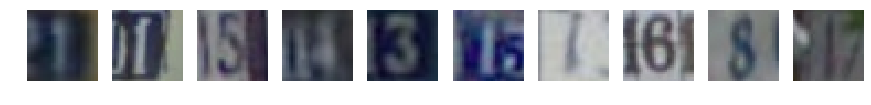

In [7]:
# Display a random sample of original color images before preprocessing
fig, axes = plt.subplots(1, 10, figsize=(15, 1.5))
for i in range(10):
    random_index = np.random.randint(0, X_train_full.shape[3])
    axes[i].imshow(X_train_full[:, :, :, random_index])
    axes[i].axis('off')
plt.show()

In [8]:
# Convert the training and test images to grayscale
X_train_gray = np.mean(X_train_full, axis=3, keepdims=True)
X_test_gray = np.mean(X_test_full, axis=3, keepdims=True)

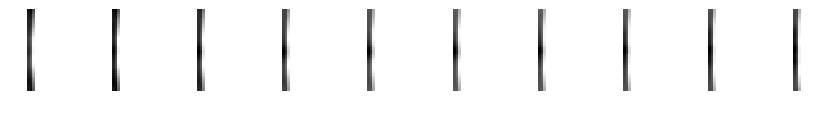

In [9]:
# Display a random sample of grayscale images before preprocessing
X_train_gray = np.mean(X_train_full, axis=3, keepdims=True)

fig, ax = plt.subplots(1, 10, figsize=(15, 1.5))
for i in range(10):
    ax[i].set_axis_off()
    ax[i].imshow(np.squeeze(X_train_gray[i]), cmap="gray")
    
plt.show()

### -------------------------------

In [10]:
# Preprocess the data
X_train_full = X_train_full / 255.0  # Normalize pixel values to be between 0 and 1
X_test_full = X_test_full / 255.0

In [11]:
# Reshape the data to have 3 channels (for RGB) and add channel dimension
X_train_full = X_train_full.reshape((X_train_full.shape[3], 32, 32, 3)).transpose(0, 2, 1, 3)
X_test_full = X_test_full.reshape((X_test_full.shape[3], 32, 32, 3)).transpose(0, 2, 1, 3)

In [12]:
# Convert labels to one-hot encoding
y_train_full[y_train_full == 10] = 0  # Replace label 10 with 0
y_train_full = tf.keras.utils.to_categorical(y_train_full, 10)

In [13]:
y_test_full[y_test_full == 10] = 0  # Replace label 10 with 0
y_test_full = tf.keras.utils.to_categorical(y_test_full, 10)

In [14]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

In [15]:
X_train.shape, y_train.shape

((8000, 32, 32, 3), (8000, 10))

## 2. MLP neural network classifier
* Build an MLP classifier model using the Sequential API. Your model should use only Flatten and Dense layers, with the final layer having a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different MLP architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 4 or 5 layers._
* Print out the model summary (using the summary() method)
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run. 
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* As a guide, you should aim to achieve a final categorical cross entropy training loss of less than 1.0 (the validation loss might be higher).
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [16]:
# Build the MLP model
mlp_model = Sequential([
            Flatten(input_shape=(32, 32, 3)),
            Dense(256, activation='relu'),
            Dense(128, activation='relu'),
            Dense(64, activation='relu'),
            Dense(10, activation='softmax')
            ])

In [17]:
# Print the model summary
mlp_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               786688    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                650       
Total params: 828,490
Trainable params: 828,490
Non-trainable params: 0
_________________________________________________________________


In [18]:
# Compile the model
mlp_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
# Set up callbacks
checkpoint_callback = ModelCheckpoint("best_mlp_model.h5", save_best_only=True)
early_stopping_callback = EarlyStopping(patience=5, restore_best_weights=True)

In [20]:
# Train the model
history = mlp_model.fit(X_train, y_train, epochs=10, validation_split=0.2, callbacks=[checkpoint_callback, early_stopping_callback])

Train on 6400 samples, validate on 1600 samples
Epoch 1/10
6400/6400 [==============================] - 11s 2ms/sample - loss: 2.2872 - accuracy: 0.1630 - val_loss: 2.2483 - val_accuracy: 0.2000
Epoch 2/10
6400/6400 [==============================] - 8s 1ms/sample - loss: 2.2485 - accuracy: 0.1809 - val_loss: 2.2543 - val_accuracy: 0.1381
Epoch 3/10
6400/6400 [==============================] - 9s 1ms/sample - loss: 2.2393 - accuracy: 0.1880 - val_loss: 2.2578 - val_accuracy: 0.2000
Epoch 4/10
6400/6400 [==============================] - 9s 1ms/sample - loss: 2.2385 - accuracy: 0.1892 - val_loss: 2.2494 - val_accuracy: 0.2000
Epoch 5/10
6400/6400 [==============================] - 9s 1ms/sample - loss: 2.2374 - accuracy: 0.1880 - val_loss: 2.2445 - val_accuracy: 0.2000
Epoch 6/10
6400/6400 [==============================] - 9s 1ms/sample - loss: 2.2382 - accuracy: 0.1870 - val_loss: 2.2475 - val_accuracy: 0.2000
Epoch 7/10
6400/6400 [==============================] - 9s 1ms/sample - los

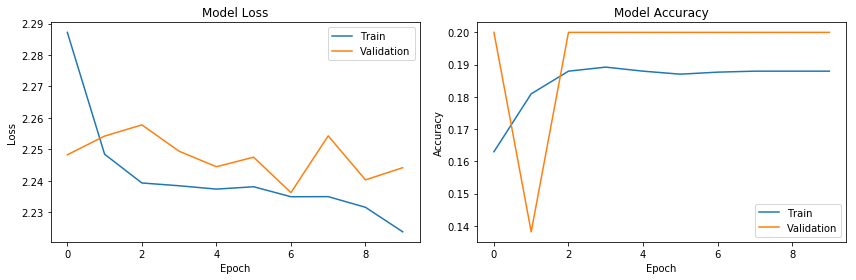

In [21]:
# Plot learning curves
plt.figure(figsize=(12, 4))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.tight_layout()
plt.show()

## 3. CNN neural network classifier
* Build a CNN classifier model using the Sequential API. Your model should use the Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense and Dropout layers. The final layer should again have a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different CNN architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 2 or 3 convolutional layers and 2 fully connected layers.)_
* The CNN model should use fewer trainable parameters than your MLP model.
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run.
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* You should aim to beat the MLP model performance with fewer parameters!
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [22]:
cnn_model = Sequential([
            # Convolutional Block 1
            Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
            BatchNormalization(),
            MaxPool2D((2, 2)),
            Dropout(0.25),
    
            # Convolutional Block 2
            Conv2D(64, (3, 3), activation='relu'),
            BatchNormalization(),
            MaxPool2D((2, 2)),
            Dropout(0.25),
    
            # Convolutional Block 3
            Conv2D(128, (3, 3), activation='relu'),
            BatchNormalization(),
            MaxPool2D((2, 2)),
            Dropout(0.25),
    
            # Flatten and Dense Layers
            Flatten(),
            Dense(512, activation='relu'),
            BatchNormalization(),
            Dropout(0.5),
    
            # Output Layer
            Dense(10, activation='softmax')
])

In [23]:
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 30, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 13, 13, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)         

In [24]:
# Compile the model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [25]:
# Model Checkpoint and Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_cnn_model.h5', monitor='val_accuracy', save_best_only=True)

In [27]:
history = cnn_model.fit(
            X_train, y_train,
            epochs=10,
            validation_data=(X_val, y_val),
            callbacks=[checkpoint, early_stopping])

Train on 8000 samples, validate on 2000 samples
Epoch 1/10
8000/8000 [==============================] - 99s 12ms/sample - loss: 3.0667 - accuracy: 0.1145 - val_loss: 8.8602 - val_accuracy: 0.0600
Epoch 2/10
8000/8000 [==============================] - 96s 12ms/sample - loss: 2.5385 - accuracy: 0.1363 - val_loss: 19.0092 - val_accuracy: 0.1055
Epoch 3/10
8000/8000 [==============================] - 96s 12ms/sample - loss: 2.3776 - accuracy: 0.1391 - val_loss: 12.7429 - val_accuracy: 0.0970
Epoch 4/10
8000/8000 [==============================] - 99s 12ms/sample - loss: 2.3224 - accuracy: 0.1531 - val_loss: 9.6308 - val_accuracy: 0.0960
Epoch 5/10
8000/8000 [==============================] - 97s 12ms/sample - loss: 2.2986 - accuracy: 0.1612 - val_loss: 5.6817 - val_accuracy: 0.1450
Epoch 6/10
8000/8000 [==============================] - 96s 12ms/sample - loss: 2.2863 - accuracy: 0.1675 - val_loss: 3.5921 - val_accuracy: 0.1415
Epoch 7/10
8000/8000 [==============================] - 99s 12

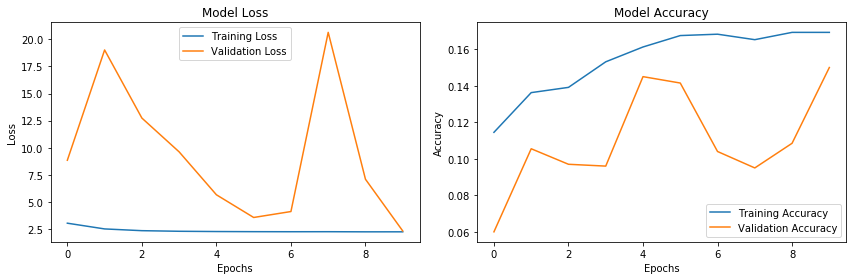

In [29]:
# Plot learning curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [31]:
# Evaluate the model on the test set
test_loss, test_accuracy = cnn_model.evaluate(X_test_full, y_test_full)

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [32]:
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

Test Loss: 2.2892
Test Accuracy: 14.41%


## 4. Get model predictions
* Load the best weights for the MLP and CNN models that you saved during the training run.
* Randomly select 5 images and corresponding labels from the test set and display the images with their labels.
* Alongside the image and label, show each model’s predictive distribution as a bar chart, and the final model prediction given by the label with maximum probability.

In [33]:
# Load best weights for MLP model
mlp_model.load_weights('best_mlp_model.h5')

In [34]:
# Load best weights for CNN model
cnn_model.load_weights('best_cnn_model.h5')

In [38]:
# Evaluate MLP model on test set
mlp_test_loss, mlp_test_accuracy = mlp_model.evaluate(X_test_full, y_test_full);

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [39]:
print(f'MLP Test Loss: {mlp_test_loss:.4f}')
print(f'MLP Test Accuracy: {mlp_test_accuracy * 100:.2f}%')

MLP Test Loss: 2.2286
MLP Test Accuracy: 19.68%


In [40]:
# Evaluate CNN model on test set
cnn_test_loss, cnn_test_accuracy = cnn_model.evaluate(X_test_full, y_test_full)

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [41]:
print(f'CNN Test Loss: {cnn_test_loss:.4f}')
print(f'CNN Test Accuracy: {cnn_test_accuracy * 100:.2f}%')

CNN Test Loss: 2.2892
CNN Test Accuracy: 14.41%


In [42]:
# Randomly select 5 indices from the test set
random_indices = np.random.choice(len(X_test_full), size=5, replace=False)

# Get the corresponding images and labels
selected_images = X_test_full[random_indices]
selected_labels = y_test_full[random_indices]

# Convert one-hot encoded labels back to integer labels
selected_labels = np.argmax(selected_labels, axis=1)


In [45]:
# Make predictions
mlp_predictions = mlp_model.predict(selected_images)
cnn_predictions = cnn_model.predict(selected_images)

In [46]:
# Convert predictions to class labels
mlp_predicted_labels = np.argmax(mlp_predictions, axis=1)
cnn_predicted_labels = np.argmax(cnn_predictions, axis=1)

In [48]:
# Define the class names (assuming labels represent digits 0-9)
class_names = [str(i) for i in range(10)]

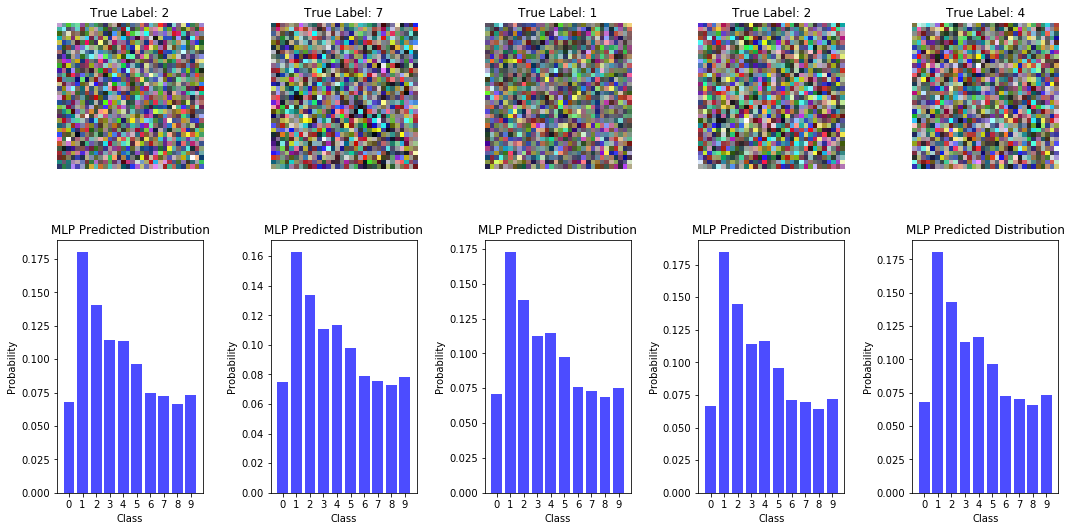

In [49]:
# Display the images with true labels and MLP predicted probabilities
plt.figure(figsize=(15, 8))

for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(selected_images[i])
    plt.title(f"True Label: {class_names[selected_labels[i]]}")
    plt.axis('off')

    plt.subplot(2, 5, i + 6)
    plt.bar(range(10), mlp_predictions[i], color='blue', alpha=0.7)
    plt.xticks(range(10), class_names)
    plt.xlabel('Class')
    plt.ylabel('Probability')
    plt.title(f"MLP Predicted Distribution")

plt.tight_layout()
plt.show()

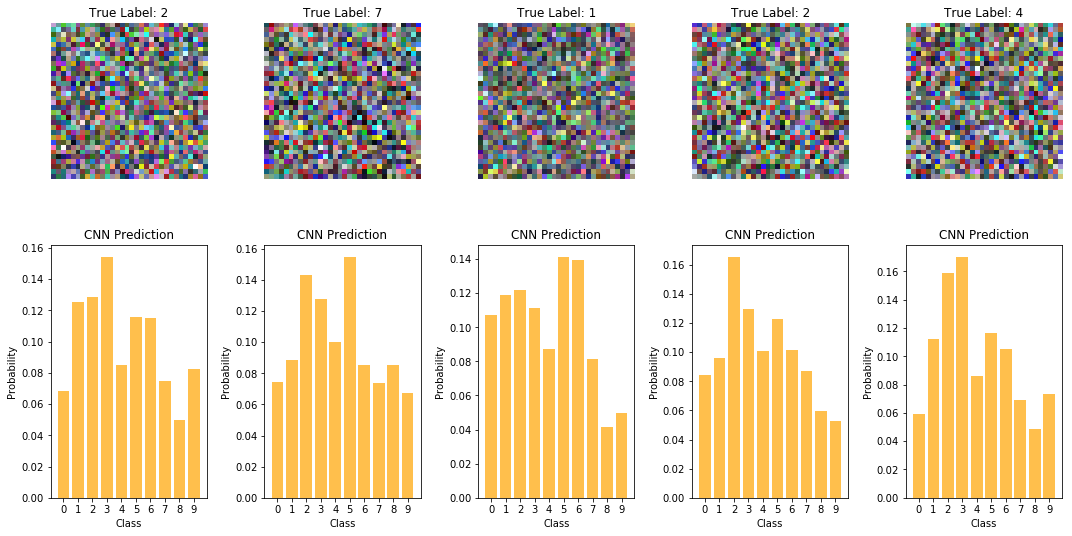

In [50]:
# Display the images with true labels and predicted distributions for CNN
plt.figure(figsize=(15, 8))

for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(selected_images[i])
    plt.title(f"True Label: {class_names[selected_labels[i]]}")
    plt.axis('off')

    plt.subplot(2, 5, i + 6)
    plt.bar(range(10), cnn_predictions[i], color='orange', alpha=0.7)
    plt.xticks(range(10), class_names)
    plt.xlabel('Class')
    plt.ylabel('Probability')
    plt.title(f"CNN Prediction")

plt.tight_layout()
plt.show()